# Аналіз GPS-даних руху київського громадського транспорту

GPS-дані руху громадського транспорту, які використовує [EasyWay](https://www.eway.in.ua/ua/cities/kyiv) можуть бути корисні не лише пасажирам. Такі дані можуть допомогти КП "Київпастранс" покращити роботу громадського транспорту і в перспективі бути одним з джерел розуміння київської мобільності та допомагати створювати стратегічні плани розвитку транспорту.

Я зібрав дані за один день - понеділок $13.07.2020$ року, їх можна знайти [тут](https://drive.google.com/file/d/1fqJMgk2vfK75Omn84OotUilFfA2_19BF/view?usp=sharing). Архів за посиланням складається з текстових файлів, кожний з яких є однією відповіддю сервера на запит, назви файлів відповідають datetime'ам, коли запит було надіслано. Також для роботи був потрібен опис системи громадського транспорту Києва у форматі GTFS static, його можна знайти [тут](https://drive.google.com/file/d/1CRIQJ9qKi0JOWiYzNIGWU4HUmL5WQqku/view?usp=sharing). [Тут](https://developers.google.com/transit/gtfs/reference) можна почитати про формат GTFS.

In [1]:
#основний функціонал винесений в бібліотеку
from urban_lib import GTFS_utils

Kyiv_transit = GTFS_utils()

In [2]:
from urban_lib import Visualizer
import matplotlib.pyplot as plt

Visualizer.set_style()

prykmetnyk = {"Трамвай": "трамвайному", "Тролейбус": "тролейбусному",
              "Автобус": "автобусному", "Міська електричка": "міської електрички"}

def visualize_route(transport_type, no, for_fr, for_t, back_fr, back_t,
                    for_stop_p, for_stop_n, back_stop_p, back_stop_n):
    fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (14, 12))
    ax1.xaxis.set_tick_params(labelbottom = True)
    
    if transport_type != "Міська електричка":
        suptitle = "Всі рейси на {} маршруті №{} в понеділок, 13 липня 2020 р.".\
        format(prykmetnyk[transport_type], no)
    else:
        suptitle = "Всі рейси на маршруті {} №{} в понеділок, 13 липня 2020 р.".\
        format(prykmetnyk[transport_type], no)
    fig.suptitle(suptitle, fontweight = "bold", size = 18, y = 0.95)
    
    Visualizer.flow_of_traffic_graph(ax1, back_t, back_fr, back_stop_p, back_stop_n, "Назва зупинки",
                                     "Рейси в напрямку {} - {}".format(back_stop_n[0], back_stop_n[-1]))
    #симетрично відображаємо один напрямок для кращої читабельності
    for_stop_p = [1 - i for i in for_stop_p]
    for_fr = [[1 - j for j in i] for i in for_fr]
    Visualizer.flow_of_traffic_graph(ax2, for_t, for_fr, for_stop_p, for_stop_n, "Назва зупинки",
                                     "Рейси в напрямку {} - {}".format(for_stop_n[0], for_stop_n[-1]))
    
    plt.show()

In [3]:
#метод, що дістає інформацію про конкретний маршрут
def get_route_info(transport_type, no):
    route_id = Kyiv_transit.get_route_id(transport_type, no)
    for_ll, back_ll = Kyiv_transit.forward_latlons[route_id], Kyiv_transit.backward_latlons[route_id]
    for_len, back_len = Kyiv_transit.forward_lens[route_id], Kyiv_transit.backward_lens[route_id]
    for_pl, back_pl = Kyiv_transit.forward_pathlens[route_id], Kyiv_transit.backward_pathlens[route_id]

    forward_fractions, forward_times = Kyiv_transit.route_fractions_from_id(route_id, for_ll, for_len, for_pl)
    backward_fractions, backward_times = Kyiv_transit.route_fractions_from_id(route_id, back_ll, back_len, back_pl)
    splited_forward_fractions, splited_forward_times = Kyiv_transit.split_fractions_into_trips(forward_fractions,
                                                                                               forward_times)
    splited_backward_fractions, splited_backward_times = Kyiv_transit.split_fractions_into_trips(backward_fractions,
                                                                                                 backward_times)
    forward_trip_id = Kyiv_transit.forward_trip_id[route_id]
    forward_stop_positions, forward_stop_names = Kyiv_transit.get_route_stops(forward_trip_id, for_ll, for_len, for_pl)
    backward_trip_id = Kyiv_transit.backward_trip_id[route_id]
    backward_stop_positions, backward_stop_names = Kyiv_transit.get_route_stops(backward_trip_id, back_ll, back_len, back_pl)
    
    return (splited_forward_fractions, splited_forward_times, splited_backward_fractions, splited_backward_times,
            forward_stop_positions, forward_stop_names, backward_stop_positions, backward_stop_names)

def get_route_info_and_visualize(transport_type, no):
    route_info_ = get_route_info(transport_type, no)
    
    visualize_route(transport_type, no, *route_info_)

In [4]:
import pandas as pd
import numpy as np

## Найзавантаженіші, найшвидші та найповільніші маршрути

Складемо декілька хіт-парадів київського транспорту, just for fun.

In [5]:
#через велику кількість обчислень відстані, цей блок працює дуже довго
speeds, all_dist = {}, {}
for route_id_ in Kyiv_transit.routes_info:
    _, _, all_dist[route_id_], all_time = Kyiv_transit.get_cleaned_positions(route_id_)
    speeds[route_id_] = Kyiv_transit.calc_speed(all_dist[route_id_], None, None, timedelta_ = all_time)

C:\Users\dmytr\OneDrive\Документы\urban_lib.py:322: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cosine_angle)


In [6]:
columns = ['Тип транспорту', 'Номер маршруту', 'Кінцеві зупинки',
           'Середня швидкість на маршруті, км/год', 'Загальна відстань, пройдена за день, км']
routes_info_and_speeds = [(*info, speeds[rid], all_dist[rid]) for rid, info in Kyiv_transit.routes_info.items()]
routes_no_nones = [x for x in routes_info_and_speeds if x[3] is not None]

In [7]:
def style_df_top_10(df, columns):
    html = df.head(10).style.set_properties(subset = columns[3:],
                                     **{'max-width': '10px', 'font-size': '14pt', 'text-align': "center"})\
    .set_properties(subset = columns[1:2], **{'max-width': '10px', 'font-size': '12pt', 'text-align': "center"})\
    .set_properties(subset = columns[0:1], **{'max-width': '300px', 'font-size': '10pt', 'text-align': "center"})\
    .set_properties(subset = columns[2:3], **{'max-width': '300px', 'font-size': '10pt', 'text-align': "center"})
    return html.format({columns[3]: "{:.1f}", columns[4]: "{:.0f}"})\
    .set_table_styles([dict(selector = "th", props = [("font-size", "130%"), ("text-align", "center")])])

In [8]:
columns_longest = list(zip(['10 маршрутів київського наземного громадського транспорту, що проїхали найбільше км. (за 13.07.2020)'] * 5,
                           columns))             
columns_longest = pd.MultiIndex.from_tuples(columns_longest)   

longest_df = pd.DataFrame(sorted(routes_info_and_speeds, key = lambda x: -x[-1]), columns = columns_longest,
                          index = range(1, len(routes_info_and_speeds) + 1))

style_df_top_10(longest_df, columns_longest)

Перші місця очікувано займають маршрути правобережного швидкісного трамвая. Враховуючи, що ці маршрути обслуговують в основному багатосекційні $26-$ та $30-$метрові трамваї, а також системи зі "зчеплених" односекційних, можна оцінити, наскільки значну транспортну роботу виконує правобережний швидкісний трамвай. Також в списку є "тимчасово виконуючий обов'язки метро на Троєщину" $114$ автобус. Але і за пробігом, і за швидкістю він поступається навіть іншому троєщинському маршруту - тролейбусу $№30$, тож "метрошних" пасажиропотоків явно не возить.

До речі, щодо тролейбуса $№30$:

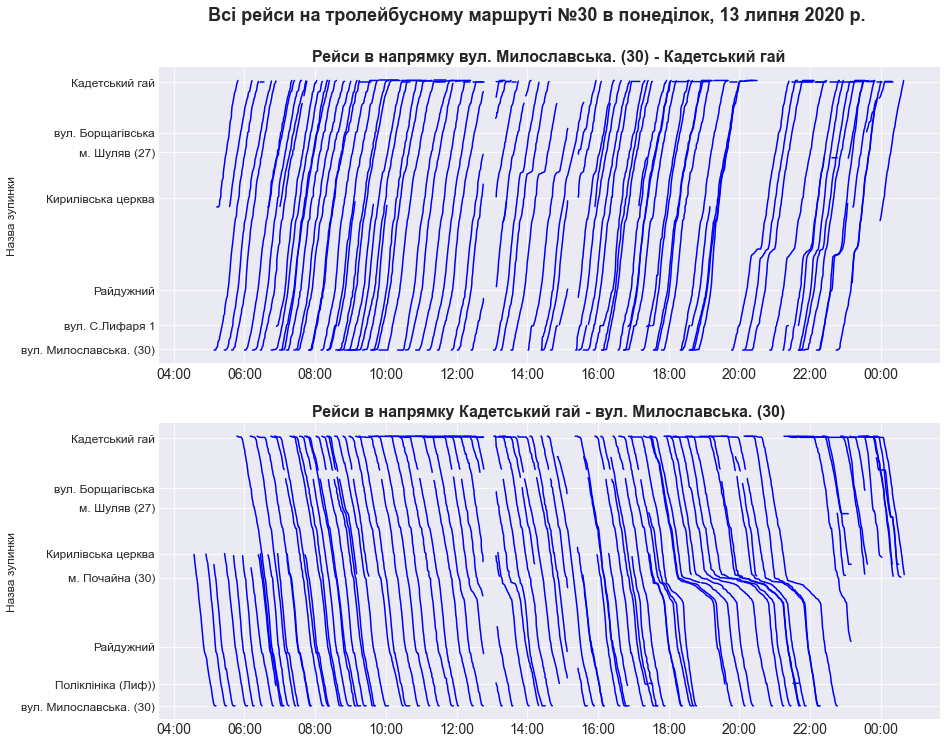

In [9]:
get_route_info_and_visualize("Тролейбус", '30')

Синіми лініями на графіку показані окремі рейси. Дуже добре видно наслідки капремонту на проспекті Бандери, що [тривав](https://www.the-village.com.ua/village/city/city-news/299311-remont-rozv-yazki-na-peretini-prospektiv-stepana-banderi-i-geroyiv-stalingrada-zavershat-do-10-serpnya) $13$ липня, коли було зібрано дані. Місто має розуміти, що у вартість дорожніх робіт входить не лише безпосередня ціна, вказана у тендері, але і додатковий час, що втрачають люди у заторах. GPS-дані дають змогу порахувати цей час для пасажирів громадського транспорту. На графіку видно, що приблизно о пів на $6$ вечора недалеко від метро Почайни почався затор в бік Троєщини, а вже за півгодини він став дуже щільним. В результаті тролейбуси (і інший громадський транспорт) добиралися до лівого берега близько години. Це також сильно дестабілізувало інтервали: так, між сусідніми рейсами з Троєщини в Кадетський гай в районі $8$ вечора пройшла ціла година.

In [10]:
columns_fastest = list(zip(['10 найшвидших маршрутів київського наземного громадського транспорту (за 13.07.2020)'] * 5,
                           columns))             
columns_fastest = pd.MultiIndex.from_tuples(columns_fastest)   

fastest_df = pd.DataFrame(sorted(routes_no_nones, key = lambda x: -x[3]), columns = columns_fastest,
                          index = range(1, len(routes_no_nones) + 1))

style_df_top_10(fastest_df, columns_fastest)

Окрім приміських та нічних маршрутів, очікувано бачимо у списку електричку, яка могла б стати повноцінним швидкісним транспортом. Подивімось на її вечірні рейси уважніше:

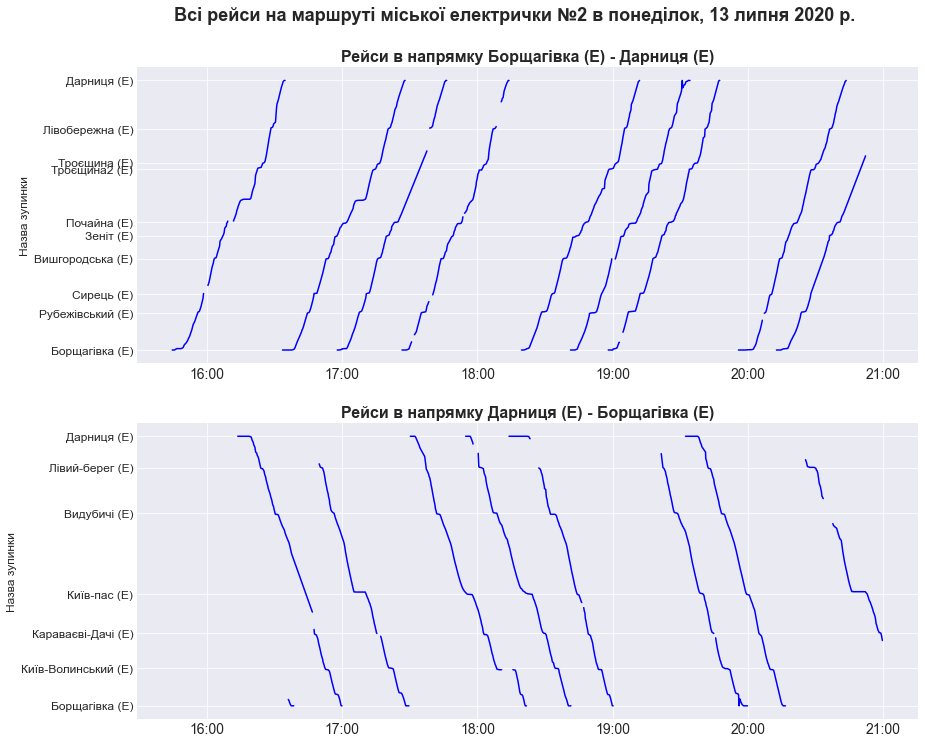

In [11]:
get_route_info_and_visualize("Міська електричка", '2')

По-перше, бачимо, що в кожному напрямку є три великі проміжки, в яких мали б бути рейси. Це [підтверджує](https://www.swrailway.gov.ua/timetable/eltrain/?rid=55) розклад на дуже некрасивому сайті залізниці. Всі ці рейси мала б виконати одна і та сама електричка, але вона, судячи з усього, не вийшла на маршрут (або в ній не працював GPS-датчик). Зверніть також увагу на перші два рейси від Борщагівки до Дарниці - на перегоні між Почайною та Троєщиною є серйозні затримки. Це електричка пропускає поїзди Укрзалізниці на Петровському залізничному мості. На жаль, на цьому мості є лише одна колія і це спричиняє затримки у русі електрички.

Розглянемо тепер один з найповільніших маршрутів київського транспорту - трамвай $18$.

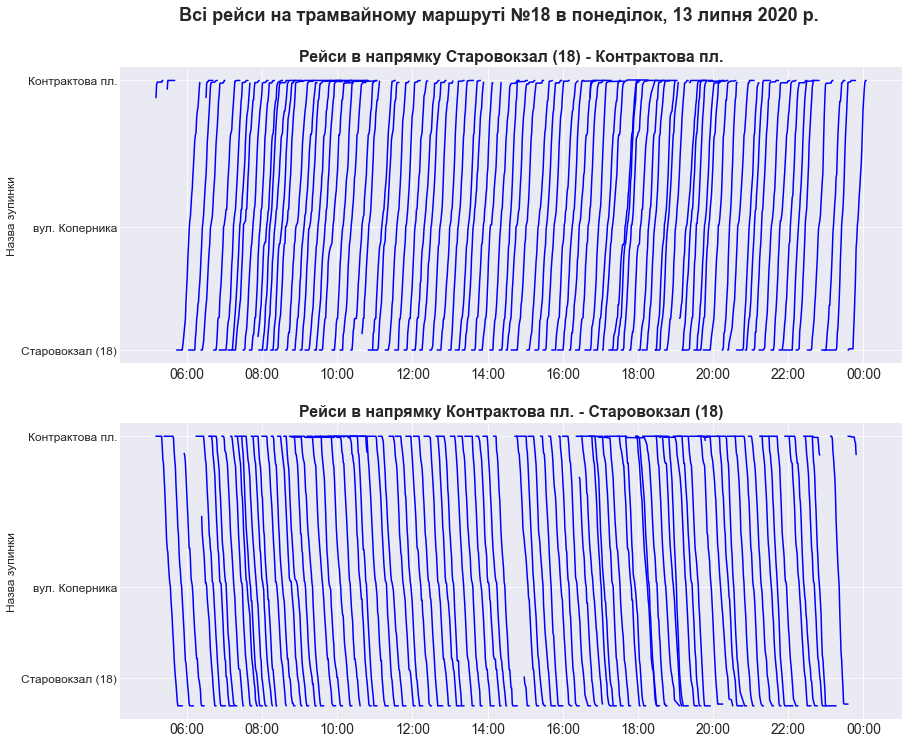

In [11]:
get_route_info_and_visualize("Трамвай", '18')

Можна бачити, що графіки руху "ламаються" в деяких місцях, що свідчить про великі затримки. В вечірній пік видно серйозні затримки, які не лише безпосередньо забирають час у пасажирів, але й розтягують інтервали.

## Приклад детальної аналітики: трамвайні світлофори

В багатьох європейських містах трамваї мають пріоритет руху на перехрестях. Це забезпечується окремими сигналами світлофорів для руху трамваїв, [ось](https://youtu.be/knbVWXzL4-4?t=386) приклад з Нідерландів. В Києві також є окремі трамвайні світлофори, але, на відміну від нідерланських, вони забезпечують пріоритет авто над трамваями. Я перебрав частину регульованих перехресть з трамвайним рухом (як з окремими трамвайними світлофорами, так і без) і виділив найкритичніші.

In [6]:
def frac_of_path(p, no, way, tr_type = 'Трамвай'):
    route_id_ = Kyiv_transit.get_route_id(tr_type, no)
    
    if way == 'back':
        latlons, lens = Kyiv_transit.backward_latlons[route_id_], Kyiv_transit.backward_lens[route_id_]
        pathlen = Kyiv_transit.backward_pathlens[route_id_]
    else:
        latlons, lens = Kyiv_transit.forward_latlons[route_id_], Kyiv_transit.forward_lens[route_id_]
        pathlen = Kyiv_transit.forward_pathlens[route_id_]
    
    return Kyiv_transit.lenght_of_path(latlons, lens, p)[0] / pathlen

In [13]:
#тут немало ручної роботи. 
#розглядались лише світлофори, перед якими не було зупинки, адже тоді не вийшло б виявити реальне джерело затримки
tram_turns = [([50.44837762, 30.49242423], "Лівий поворот з Бульварно-Кудрявської на Дмитрівську", 0.04,
               [('15', 'back'), ('18', 'back')], [0, 0]),
              ([50.44504623, 30.49233771], "Лівий поворот зі Старовокзальної на Жилянську", 0.03,
               [('1', 'back'), ('3', 'back'), ('15', 'back'), ('18', 'back')], [0, 0]),
              ([50.45753994, 30.4864025], "Перетин Дмитрівської і Чорновола (з півдня)", 0.035,
               [('15', 'back'), ('18', 'back')], [0, 0]),
              ([50.438192, 30.4100485], "Перетин бульвару В. Гавела з вулицею Каблукова (з півночі)", 0.02,
               [('14', 'back'), ('15', 'back')], [0, 0]),
              ([50.4234235 , 30.42703492], "Лівий поворот з Відрадного проспекту на бульвар В. Гавела", 0.035,
               [('14', 'for'), ('15', 'for')], [0, 0]),
              ([50.43770549, 30.40999189], "Перетин бульвару В. Гавела з вулицею Каблукова (з півдня)", 0.02,
               [('14', 'for'), ('15', 'for')], [0, 0]),
              ([50.44640822, 30.42023369], "Лівий поворот з бульвару В. Гавела на вулицю Василенка", 0.03,
               [('14', 'for'), ('15', 'for')], [0, 0]),
              ([50.45802349, 30.48594306], "Перетин Дмитрівської і Чорновола (з півночі)", 0.04,
               [('15', 'for'), ('18', 'for')], [0, 0]),
              ([50.447582, 30.491048], "Перетин Бульварно-Кудрявської і Перемоги (з півночі)", 0.025,
               [('15', 'for'), ('18', 'for')], [0, 0]),
              ([50.4455183, 30.49166412], "Правий поворот з Жилянської на Старовокзальну", 0.05,
               [('1', 'for'), ('3', 'for'), ('15', 'for'), ('18', 'for')], [0, 0]),
              ([50.467207, 30.51482552], "Перетин Межигірської з Верхнім Валом", 0.04,
               [('11', 'back'), ('12', 'back'), ('14', 'back'), ('16', 'back'), ('18', 'for'), ('19', 'for')], [0, 0]),
              ([50.49861671, 30.46236235], "Правий поворот зі Скляренка на Добрининську", 0.03,
               [('11', 'back'), ('16', 'back'), ('17', 'for')], [0, 0]),
              ([50.50636237, 30.48919439], "Перетин з колом на Малиновського/Тимошенка (з півдня)", 0.03, [('16', 'back')], [0, 0]),
              ([50.507557, 30.489201], "Перетин з колом на Малиновського/Тимошенка (з півночі)", 0.03, [('16', 'for')], [0, 0]),
              ([50.49311081, 30.46229589], "Перетин Кирилівської з Сирецькою (з півночі)", 0.03,
               [('16', 'for'), ('11', 'for'), ('12', 'for'), ('19', 'back')], [0, 0]),
              ([50.4667421, 30.51210615], "Перетин Костянтинівської з Нижнім Валом", 0.04,
               [('11', 'for'), ('12', 'for'), ('16', 'for'), ('19', 'back')], [0, 0]),
              ([50.45626372, 30.63346434], "Поворот з Гагаріна на Хоткевича (в південний бік)", 0.02,
               [('8', 'back'), ('29', 'back')], [0, 0]),
              ([50.427789, 30.636983], "Перетин Привокзальної і Дарницького шосе (з заходу)", 0.04,
               [('8', 'back'), ('22', 'for'), ('29', 'back')], [0, 0]),
              ([50.43141781, 30.65075844], "Правий поворот з Привокзальної на Ялтинську", 0.03,
               [('8', 'back'), ('29', 'back')], [0, 0]),
              ([50.42103218, 30.65815508], "Правий поворот зі Славгородської на Тростянецьку", 0.02, [('8', 'back')], [0, 0]),
              ([50.43118178, 30.65130361], "Лівий поворот з Ялтинської на Привокзальну", 0.03,
               [('8', 'for'), ('29', 'for')], [0, 0]),
              ([50.42797987, 30.63808418], "Перетин Привокзальної і Дарницького шосе (зі сходу)", 0.03,
               [('8', 'for'), ('22', 'back'), ('29', 'for')], [0, 0]),
              ([50.45258334, 30.63429806], "Перетин з бульваром Верховної Ради (з півдня)", 0.04,
               [('8', 'for'), ('22', 'back'), ('29', 'back'), ('33к', 'back')], [0, 0]),
              ([50.45558312, 30.63331213], "Правий поворот з Хоткевича на Гагаріна", 0.02,
               [('8', 'for'), ('29', 'for')], [0, 0]),
              ([50.46337091, 30.62798211], "Поворот з Братиславської на Миропільську", 0.03,
               [('22', 'back'), ('28', 'back'), ('33к', 'back'), ('35', 'back')], [0, 0]),
              ([50.48490547, 30.60347354], "Перетин Курнатовського і Стальського (з півдня)", 0.03,
               [('28', 'back'), ('33к', 'back'), ('35', 'back')], [0, 0]),
              ([50.4910606, 30.60132889], "Правий поворот з Курнатовського на Кібальчича", 0.035,
               [('28', 'back'), ('33к', 'back'), ('35', 'back')], [0, 0]),
              ([50.49158226, 30.60151188], "Лівий поворот з Кібальчича на Курнатовського", 0.04,
               [('28', 'for'), ('33к', 'for'), ('35', 'for')], [0, 0]),
              ([50.48509123, 30.60332565], "Перетин Курнатовського і Стальського (з півночі)", 0.04,
               [('28', 'for'), ('33к', 'for'), ('35', 'for')], [0, 0]),
              ([50.47270068, 30.61190995], "Перетин Миропільської і Жмаченка (з півночі)", 0.02,
               [('22', 'for'), ('28', 'for'), ('33к', 'for'), ('35', 'for')], [0, 0]),
              ([50.46386565, 30.62738589], "Поворот з Миропільської на Братиславську", 0.02,
               [('22', 'for'), ('28', 'for'), ('33к', 'back'), ('35', 'for')], [0, 0]),
              ([50.4570382, 30.63211517], "Лівий поворот з Хоткевича на Гагаріна", 0.02,
               [('28', 'for'), ('35', 'for')], [0, 0]),
              ([50.52036264, 30.45267402], "Правий поворот з Полярної на Автозаводську", 0.035,
               [('12', 'for'), ('17', 'for'), ('19', 'back')], [0, 0]),
              ([50.46642981, 30.51281584], "Перетин Валів і Костянтинівської (зі сходу)", 0.03,
               [('14', 'back'), ('18', 'for')], [0, 0]),
              ([50.46281028, 30.50690626], "Правий поворот з Валів на Глибочицьку", 0.035,
               [('14', 'back'), ('18', 'for')], [0, 0]),
              ([50.46253636, 30.49264464], "Перетин Глибочицької з Лук'янівською (зі сходу)", 0.035,
               [('14', 'back'), ('18', 'for')], [0, 0]),
              ([50.46002347, 30.48466582], "Перетин Коперника і Січових Стрільців (з заходу)", 0.035,
               [('14', 'for'), ('18', 'back')], [0, 0]),
              ([50.46085358, 30.48818086], "Лівий поворот Глибочицької після перетину з Січовими Стрільцями", 0.03,
               [('14', 'for'), ('18', 'back')], [0, 0]),
              ([50.46282606, 30.50647698], "Лівий поворот з Глибочицької на Вали", 0.03,
               [('14', 'for'), ('18', 'back')], [0, 0]),
              ([50.46615832, 30.51277119], "Правий поворот з Верхнього Валу на Костянтинівську", 0.035,
               [('14', 'for'), ('18', 'back')], [0, 0]),
              ([50.4315293 , 30.65151304], "Поворот з Бориспільської на Привокзальну", 0.035, [('22', 'back')], [0, 0]),
              ([50.484840, 30.603505], "Лівий поворот з Курнатовського на Стальського", 0.03, [('22', 'back')], [0, 0]),
              ([50.48500441, 30.60323568], "Правий поворот зі Стальського на Курнатовського", 0.025, [('22', 'for')], [0, 0]),
              ([50.43146141, 30.650568], "Поворот з Привокзальної на Бориспільську", 0.025, [('22', 'for')], [0, 0]),
              ([50.42092912, 30.6585988], "Перетин Славгородської з Тростянецькою (з півдня)", 0.025, [('29', 'for')], [0, 0])]

In [17]:
tram_info = {}

for turn_info in tram_turns:
    for route_, direction in turn_info[3]:
        route_id_ = Kyiv_transit.get_route_id('Трамвай', route_)
        if route_ not in tram_info:
            tram_info[route_] = get_route_info('Трамвай', route_)
        
        if direction == 'back':
            _, _, splited_fractions, splited_times, _, _, _, _ = tram_info[route_]
            pathlen = Kyiv_transit.backward_pathlens[route_id_]
        else:
            splited_fractions, splited_times, _, _, _, _, _, _ = tram_info[route_]
            pathlen = Kyiv_transit.forward_pathlens[route_id_]
            
        ave_deltatime = np.mean([np.mean([t - l[i] for i, t in enumerate(l[1:])]) for l in splited_times])
        interval = turn_info[2] / pathlen
        n_bins = int(1 / interval)
        splited_fractions_ = np.concatenate(tuple(splited_fractions))
        ave_npts_while_moving = np.median(np.histogram(splited_fractions_, bins = n_bins)[0])
        path_frac = frac_of_path(np.array(turn_info[0]), route_, direction)
        npts = len([1 for f in splited_fractions_ if (f > path_frac - interval / 2)\
                    and (f < path_frac + interval / 2)])
        turn_info[-1][0] += ave_deltatime.seconds * (npts - ave_npts_while_moving)
        turn_info[-1][1] += len([1 for trip in splited_fractions if (trip[0] <= path_frac)\
                                 and (path_frac <= trip[-1])])

In [18]:
columns = ['Локація', 'Маршрути трамваїв', 'Сумарний час, який трамваї чекали, год.',
           'Середній час очікування одного трамвая, сек.']
columns = list(zip(['10 перехресть в Києві, на яких трамваї втратили найбільше часу в понеділок, 13.07.2020'] * 4,
                   columns))             
columns = pd.MultiIndex.from_tuples(columns)   

tram_df = pd.DataFrame(sorted([(turn[1], ', '.join([l[0] for l in turn[3]]), round(turn[4][0] / 3600, 2),
                                round(turn[4][0] / turn[4][1], 1)) for turn in tram_turns], key = lambda x: -x[2]),
                       columns = columns, index = range(1, len(tram_turns) + 1))

styles = [dict(selector = "th", props = [("font-size", "16pt")])]
tram_html = tram_df.head(10).style.set_properties(subset = columns[2:],
                                                  **{'max-width': '10px', 'font-size': '16pt', 'text-align': "center"})\
.set_properties(subset = columns[1:2], **{'max-width': '10px', 'font-size': '12pt', 'text-align': "center"})\
.set_properties(subset = columns[0:1], **{'max-width': '300px', 'font-size': '10pt', 'text-align': "center"})
tram_html.format({columns[2]: "{:.2f}", columns[3]: "{:.1f}"})\
.set_table_styles([dict(selector = "th", props = [("font-size", "130%"), ("text-align", "center")])])

Вже зазначалося, що маршрути швидкісного трамвая $1$ і $3$ виконують величезну транспортну роботу. І все одно, на перехресті Старовокзальної і Жилянської вони чекають в середньому близько $30$ секунд. Можливо, це саме те перехрестя, де слід спробувати забезпечити пріоритет проїзду трамвая? Результати для трамваїв і для особистих авто можна буде оцінити на даних і зрозуміти, чи зменшилась загальна затримка.

Інші перехрестя показують ще гіршу середню затримку одного трамвая. $7$ з $10$ цих локацій обладнані саме окремими трамвайними світлофорами і ці світлофори явно не налаштовані пропускати трамвай в першу чергу або хоча б забезпечувати пристойний час очікування.

_Зауваження._ В останній таблиці можна помітити дизбаланси: наприклад, з неї виходить, що в один бік вулиці Привокзальної за день проїхало більше трамваїв, ніж в інший. Це явно так не має бути, кількості трамваїв, що проїхали в обидва боки, мають співпадати. Причина - не дуже чисті динамічні та неточні статичні дані, ми недораховуємось невеликої частини трамваїв через ці проблеми. Це навряд сильно впливає на правильність підрахунку середнього часу очікування, а от сумарний час очікування імовірно дещо занижається.

## Інші приклади проблем, які можуть показати дані

__Тролейбуси ходять "гуськом".__ Знайомий розповів мені, що на $12$ маршруті тролейбуси часто ходять один за одним. І дійно:

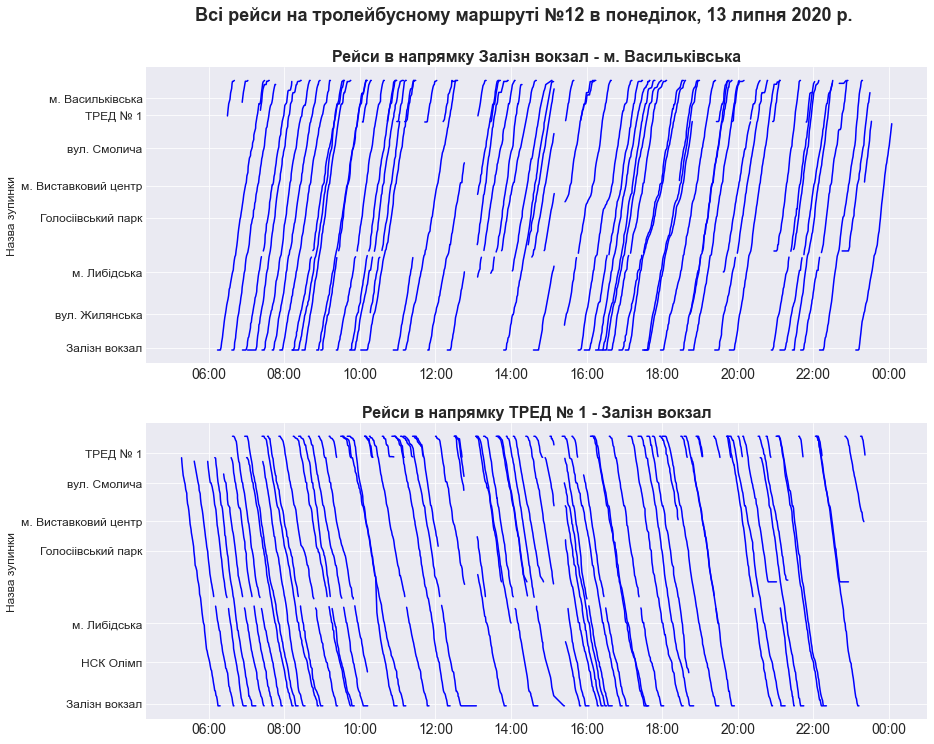

In [20]:
get_route_info_and_visualize("Тролейбус", '12')

Два, а подекуди і три тролейбуси їдуть один за одним без видимої на те причини.

__Каравани з трамваїв.__ Коли трамвай вимушено зупиняється на маршруті, це повністю паралізує рух трамваїв, що їдуть за ним. Можна систематизувати дані про такі випадки щоб розуміти, які частини полотна чи контактної мережі їх спричиняють. Приклад затримки на маршруті $8$ (в районі Харківського масиву о $5$ годині вечора).

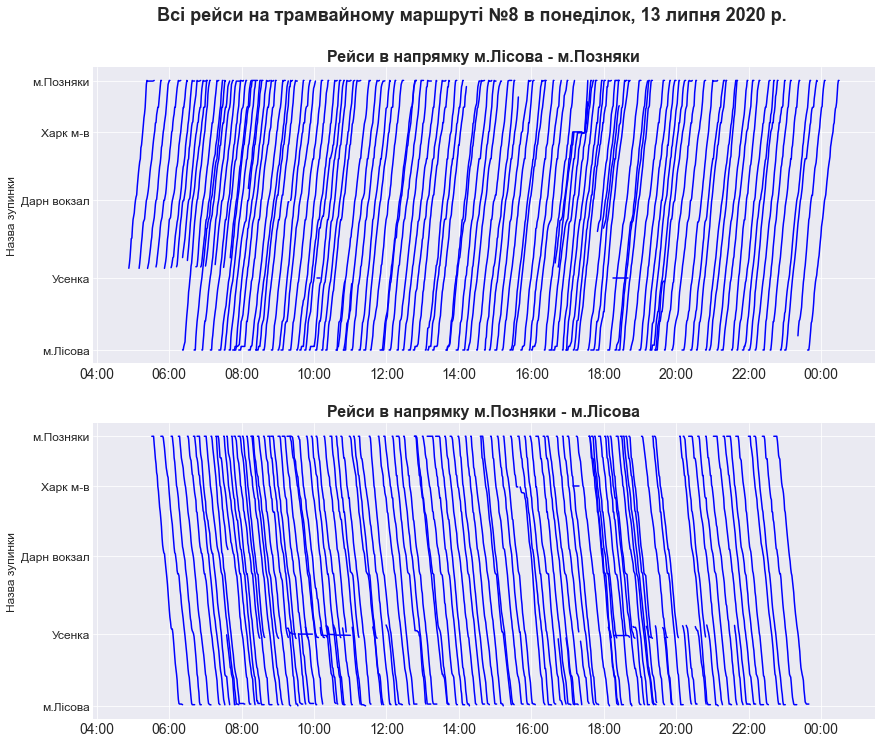

In [21]:
get_route_info_and_visualize("Трамвай", '8')

## Висновки

GPS-дані руху громадського транспорту дозволяють об'єктивно вимірювати показники роботи транспорту. Зокрема, вони ілюструють один з аспектів київської транспортної політики - пріоритезація руху особистих авто, а не громадського транспорту. Але мають і багато інших потенційних застосувань, до яких я не дійшов в рамках цього посту.

Дякую за увагу!